In [2]:
from imp import reload
import sys
import os
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
# Use Type 1 fonts in plots.
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = False
# Do not wrap long lines
np.set_printoptions(linewidth=np.nan)
sns.set_style("whitegrid")
import runner
import umm

## Running UMM and CEGO over one instance

The next cell allows running CEGO and UMM over a chosen instance and with the selected parameters

In [2]:
# MANUEL:  We do not need this for reproducibility, so we should move it to a different notebook.
reload(runner)
instance_name="LOP-synthetic,seed=123456,n=20,m=200,phi=0.9"
# instance_name="pfsp/rec19.txt"
# instance_name="lop/xLOLIB/N-be75eec_150"
# instance_name="lop/xLOLIB/N-be75eec_150"
# instance_name="qap/nug12.dat"
budgetGA=10**3
seed=2
budget=400
m_ini=10
budgetMM=10
r_1 = [.1]
r_2 = [.9]
res = []
for ratio_samples_learn in r_1:
  for weight_mass_learn in r_2:
    out_filename = "pickles/"+instance_name.replace("/", "__").replace(".txt", "")
    df = runner.run_once("uMM", instance_name, seed,budget = budget, m_ini = m_ini, budgetMM = budgetMM, 
                         ratio_samples_learn = ratio_samples_learn, weight_mass_learn = weight_mass_learn, out_filename = out_filename)
    res.append([out_filename,ratio_samples_learn, weight_mass_learn,df.Fitness.min()])
    print("best found",df.Fitness.min())
#out_filename="local_new_CEGO"
#runner.run_once("CEGO", instance_name, seed,budget = budget, m_ini = m_ini, budgetGA = budgetGA, out_filename = out_filename)

Generating synthetic LOP instance with seed=123456 n=20 m=200 phi=0.9
identity, reverse and best-known fitnesses 100.75999999999999 89.24 None
best found 0.0039752650176679925


The following piece of code plots the results of the previous experiment

instance name LOP-synthetic,seed=123456,n=20,m=200,phi=0.9 - time 60.66
0.0039752650176679925


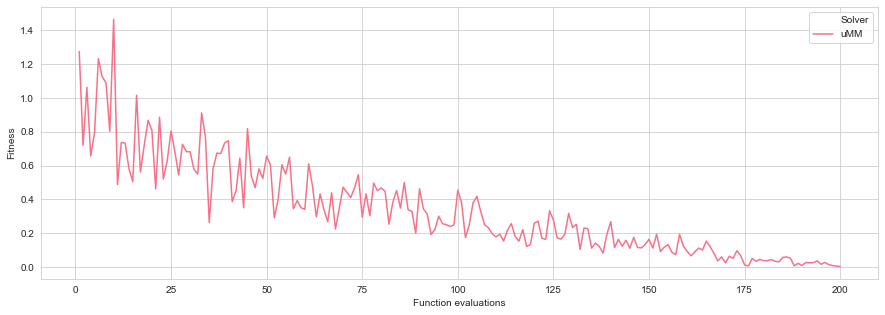

In [3]:
out_file = "pickles/"+instance_name.replace("/", "__").replace(".txt", "")
df = pd.read_pickle(out_filename+'.pkl.gz')

print("instance name", df.instance.iloc[0], "- time", round(df.run_time.iloc[0], 2))
print(df.Fitness.min())

color_variable = 'Solver'
y_variables = ['Fitness']#,'Distance','phi_sample'
palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
for y_variable in y_variables:
    plt.figure(figsize=(15,5))
    sns.lineplot(x='Function evaluations',y=y_variable,hue='Solver',data=df, palette=palette)
    plt.show()

# Plotting the results of the experiments in the paper 
## Which value of $r_1$ (ratio_samples_learn) and $r_2$ (weight_samples_learn) is the best for each instance?

The learning rate $\rho$ (uBorda parameter) is **not** set manually. Instead, we use these two parameters to obtain a more interpretable setting: The value of $\rho$ is set at each iteration and depends on the set of function evaluations $F$. Parameter $\rho$ is set such that the largest $r_1$\% of the mass of the weights is concentrated in the best $r_2$\% of the solutions in $S$, i.e., 

$$
r_1 \sum_{\sigma\in S}\rho^{f(\sigma)} =  \sum_{\sigma\in S'}\rho^{f(\sigma)} \text{where} |S'| = r_2|S| \land \forall \sigma'\in S', \sigma\in S\setminus S' : f(\sigma')\geq f(\sigma)
$$


Therefore, for each instance, we plot the mean of the best fitnesses over 10 repetitions as a function of $r_1$ and $r_2$. Since we are minimizing, the lower the better. 

Overall, the values ($r_1, r_2$)=(.1,.9) have good performance, we will use this configuration for the rest of the experimental section. 

For the LOP instances (synthetic and real) the best fitness function changes smoothly when we change the parameters
For the QAP and PFSP this does not happen, meaning that the convergence to the optimal is not smooth

N-atp111


findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.


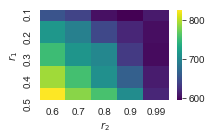

N-atp134


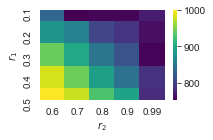

N-be75eec-150


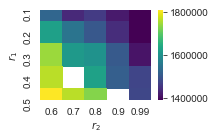

N-be75np-150


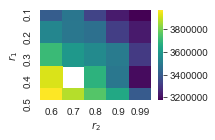

N-p50-01


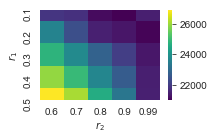

N-p50-02


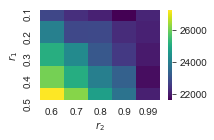

N-t1d100.01


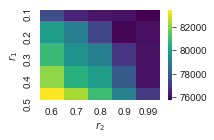

N-t1d100.02


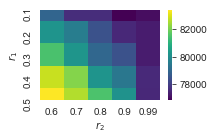

N-t1d150.01


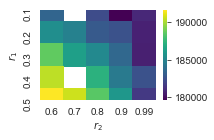

N-t1d150.02


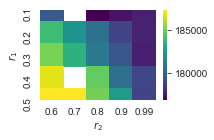

N-t2d150.01


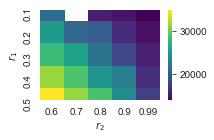

N-t2d150.02


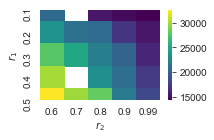

kra32.dat


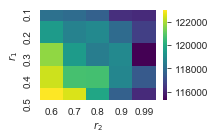

nug12.dat


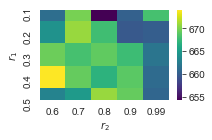

nug30.dat


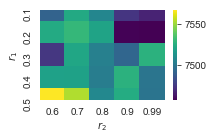

rec05


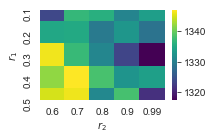

rec13


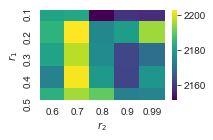

rec19


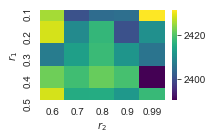

rec31


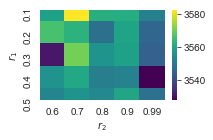

tho30.dat


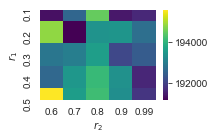

In [2]:
# MANUEL: How do we get results/results.csv ?
df = pd.read_csv('results/results.csv',index_col=0)
df.columns = [c if c!='min' else 'best' for c in df.columns]
df = pd.pivot_table(df,index=['filename','ratio','weight'],values='best',aggfunc={np.mean,np.min, np.std})#.reset_index()
df.columns = ['best_'+ c for c in df.columns]
dfres = df.reset_index()
dfres
for instance_name in dfres.filename.drop_duplicates().values:
  print(instance_name, )
  plt.figure(figsize=(3,2))
  sns.set_style("whitegrid")
  square = dfres[dfres.filename == instance_name].pivot_table(index='ratio', columns='weight', values='best_mean')
  sns.heatmap(square, cmap="viridis")
  plt.tight_layout()
  plt.xlabel(r'$r_2$')
  plt.ylabel(r'$r_1$')
  plt.savefig('img/heatmap_'+instance_name.replace('.','_')+'.pdf')

  plt.show()

In [27]:
# MANUEL: What is this cell doing?
a = dfres.groupby(['ratio','weight','filename']).best_mean.mean().reset_index()
a#.groupby('filename').rank()
a["totalrank"] = a.groupby("filename")["best_mean"].rank("dense", ascending=True)
a[a.filename=='N-atp111']
a
#a[(a.ratio==0.1)&(a.weight==0.9)].totalrank.mean()
a[a.totalrank==1]

,ratio,weight,filename,best_mean,totalrank
21,0.1,0.70,N-atp134,7.520000e+02,1.0
45,0.1,0.80,N-t1d150.02,1.769090e+05,1.0
49,0.1,0.80,nug12.dat,6.544000e+02,1.0
52,0.1,0.80,rec13,2.151200e+03,1.0
56,0.1,0.90,N-atp111,5.943333e+02,1.0
60,0.1,0.90,N-p50-01,2.102760e+04,1.0
61,0.1,0.90,N-p50-02,2.161360e+04,1.0
63,0.1,0.90,N-t1d100.02,7.682770e+04,1.0
64,0.1,0.90,N-t1d150.01,1.796552e+05,1.0
79,0.1,0.99,N-be75np-150,3.175422e+06,1.0


## Synthetic datasets (LOP)


  The instances $M$ follow this distribution $M_\phi[i,j]$
  $$M_\phi[i,j] = h(j-i+1,\phi) - h(j-i,\phi),$$ where $$h(k,\phi)=\frac{k}{1-\phi^k} \enspace.$$
  
Taking different values of $\phi$ we controll the uniformity of $M$.
  
In the next cell we plot the results over the synthetic instances

0    NaN
0    0.5
Name: phi_instance, dtype: float64 8000 4000 4000
0    NaN
0    0.7
Name: phi_instance, dtype: float64 8000 4000 4000
0    NaN
0    0.9
Name: phi_instance, dtype: float64 8000 4000 4000
ranking of the solvers by fitness
['uMM ' 'uMM ' 'uMM ' 'uMM ' 'CEGO' 'uMM ' 'CEGO' 'uMM ' 'uMM ' 'CEGO' 'CEGO' 'uMM ' 'CEGO' 'CEGO' 'uMM ' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'uMM ']


findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.


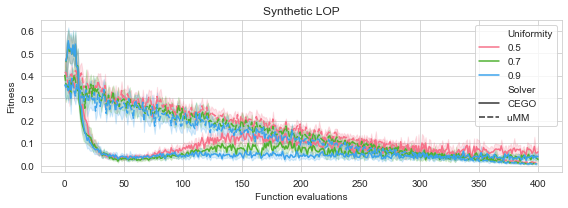

In [6]:
# Compare synthetic data in the same plot.
# Compare the convergence to lowest fitness funtion values by the two solvers
dfcego = pd.concat([pd.read_pickle('results/'+filename) for filename in os.listdir('results') for i in range(9,12) if 'pkl'in filename and 'cego-'+str(i)+'-' in filename],sort=False)
dfumm = pd.concat([pd.read_pickle('pickles/'+filename) for filename in os.listdir('pickles') if 'pkl'in filename and 'pick' in filename and 'pickCEGO.pkl' not in filename],sort=False)
dfumm.columns = [c if c!= 'Sample size' else 'Function evaluations' for c in dfumm.columns]
dfumm.columns = [c if c!= 'rep' else 'seed' for c in dfumm.columns]

lis = []
for phi in [0.5, 0.7, 0.9]: 
  a = dfcego[dfcego.instance.str.contains('phi='+str(phi))]
  b = dfumm[(dfumm.phi_instance==phi) & (dfumm.ratio_samples_learn==0.1503) & (dfumm.weight_mass_learn==0.8362)]
  df = pd.concat([a,b ],sort=False)
  df['Uniformity'] = phi
    # MANUEL: What is this printing?
  print(df.phi_instance.drop_duplicates(), len(df), len(a), len(b))
  lis.append(df)
  
df = pd.concat(lis)

print("ranking of the solvers by fitness")
print(df.groupby(['Solver','seed']).Fitness.min().reset_index().sort_values(by='Fitness').Solver.values)
color_variable = 'Uniformity'
y_variables = ['Fitness']#,'Distance','phi_sample'
palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
for y_variable in y_variables:
    plt.figure(figsize=(8,3))
    g = sns.lineplot(x='Function evaluations',y=y_variable,style='Solver', hue=color_variable,data=df, palette=palette)
    g.set_title('Synthetic LOP')
    plt.tight_layout()
    plt.savefig('img/synthetic_LOP_combined.pdf')
    plt.show()


## Real datasets (LOP, QAP, PFSP)
In the following lines we load the results of the real dataset for CEGO and UMM, plot the results and make the comparison table

In [4]:
import os.path

lis = []
for folder in ['results/lop/','results/pfsp/', 'results/qap/']: 
    for dirpath, dirnames, filenames in os.walk(folder):
        for filename in [f for f in filenames if f.endswith(".pkl.gz")]:
            lis.append(pd.read_pickle(os.path.join(dirpath, filename)))
dfcego = pd.concat(lis)
dfumm = pd.concat([pd.read_pickle('pickles/'+filename) for filename in os.listdir('pickles') if 'pkl.gz'in filename])
dfumm['instance'] = dfumm['instance'].str[2:] # to remove the initial ./


Instance:  N-t1d100.01
Saving to img/fitness_real_lop_RandA1_N-t1d100_01.pdf


findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.


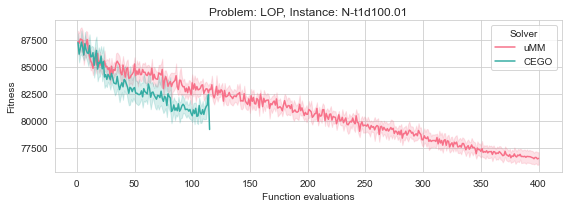

Instance:  N-t1d100.02
Saving to img/fitness_real_lop_RandA1_N-t1d100_02.pdf


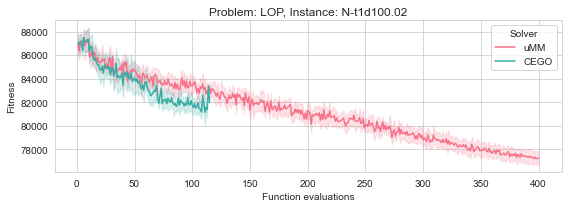

Instance:  N-t1d150.01
Saving to img/fitness_real_lop_RandA1_N-t1d150_01.pdf


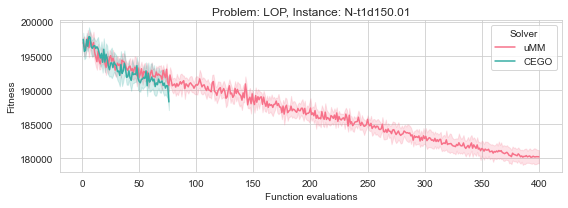

Instance:  N-t1d150.02
Saving to img/fitness_real_lop_RandA1_N-t1d150_02.pdf


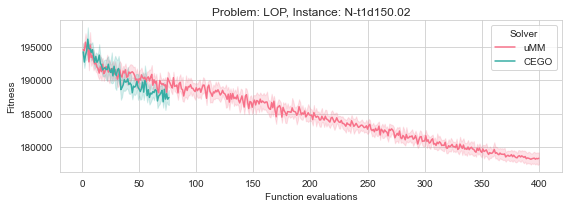

Instance:  N-t1d200.01
Saving to img/fitness_real_lop_RandA1_N-t1d200_01.pdf


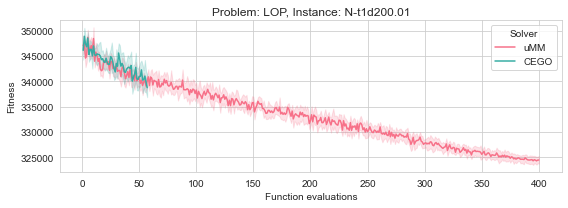

Instance:  N-t1d200.02
Saving to img/fitness_real_lop_RandA1_N-t1d200_02.pdf


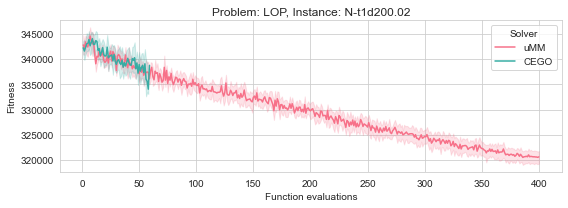

Instance:  N-t2d150.01
Saving to img/fitness_real_lop_RandA2_N-t2d150_01.pdf


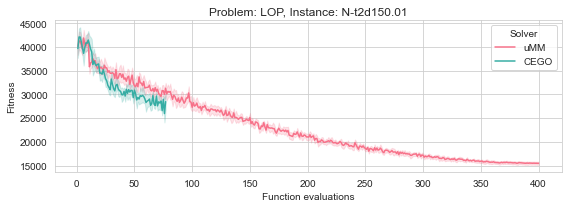

Instance:  N-t2d150.02
Saving to img/fitness_real_lop_RandA2_N-t2d150_02.pdf


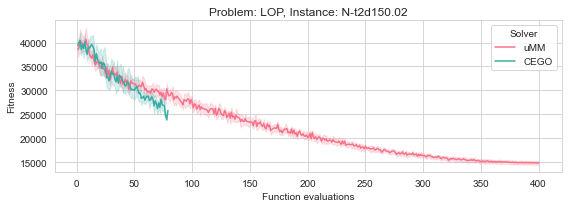

Instance:  N-t2d200.01
Saving to img/fitness_real_lop_RandA2_N-t2d200_01.pdf


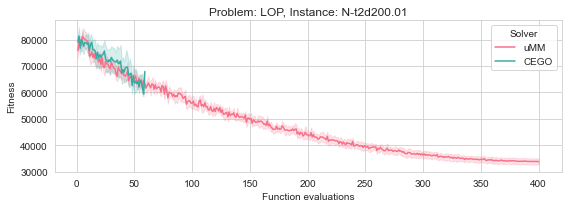

Instance:  N-t2d200.02
Saving to img/fitness_real_lop_RandA2_N-t2d200_02.pdf


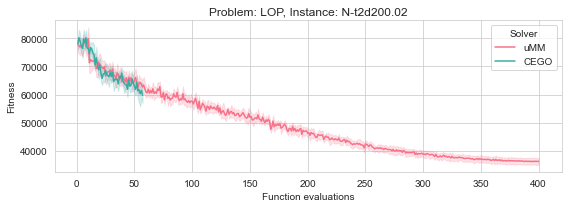

Instance:  N-p50-01
Saving to img/fitness_real_lop_RandB_N-p50-01.pdf


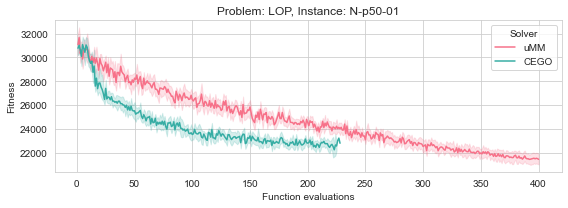

Instance:  N-p50-02
Saving to img/fitness_real_lop_RandB_N-p50-02.pdf


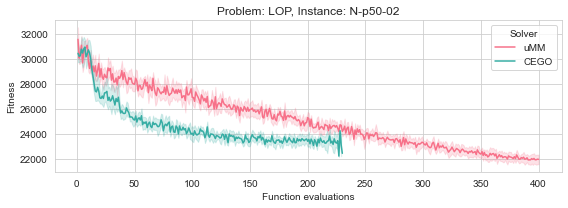

Instance:  N-be75eec_150
Saving to img/fitness_real_lop_xLOLIB_N-be75eec_150.pdf


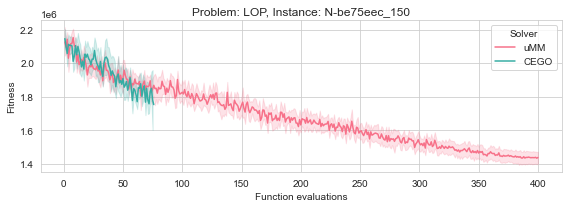

Instance:  N-be75np_150
Saving to img/fitness_real_lop_xLOLIB_N-be75np_150.pdf


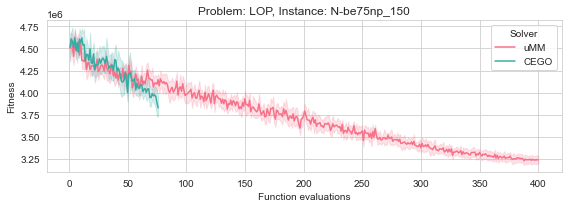

Instance:  N-be75eec_250
Saving to img/fitness_real_lop_xLOLIB_N-be75eec_250.pdf


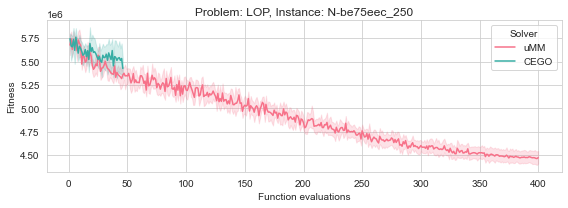

Instance:  N-be75np_250
Saving to img/fitness_real_lop_xLOLIB_N-be75np_250.pdf


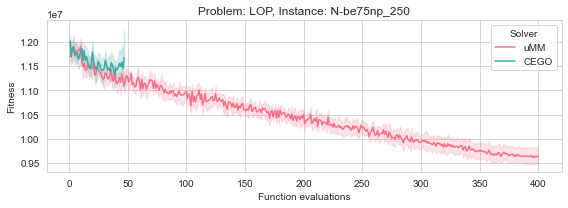

Instance:  N-atp111
Saving to img/fitness_real_lop_Spec_N-atp111.pdf


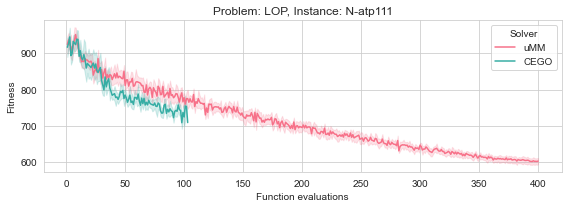

Instance:  N-atp134
Saving to img/fitness_real_lop_Spec_N-atp134.pdf


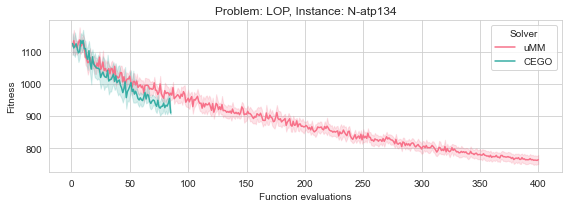

Instance:  tho30
Saving to img/fitness_real_qap_tho30_dat.pdf


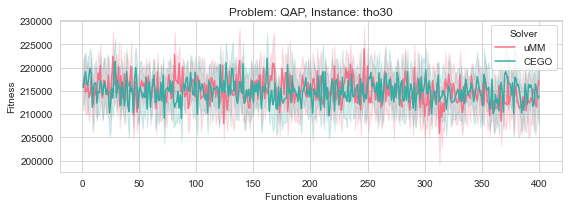

Instance:  kra32
Saving to img/fitness_real_qap_kra32_dat.pdf


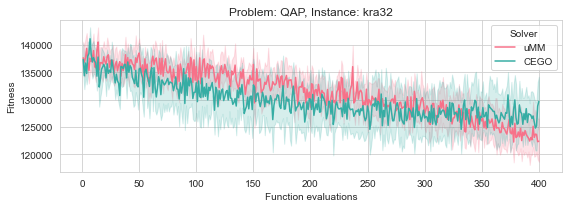

Instance:  nug30
Saving to img/fitness_real_qap_nug30_dat.pdf


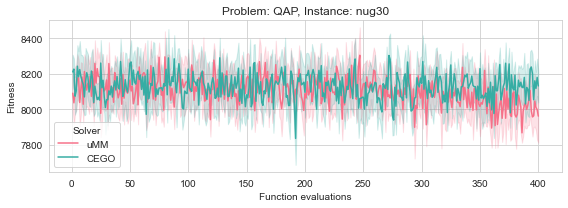

Instance:  nug12
Saving to img/fitness_real_qap_nug12_dat.pdf


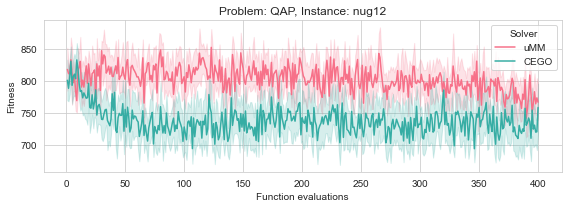

Instance:  rec05
Saving to img/fitness_real_pfsp_rec05_txt.pdf


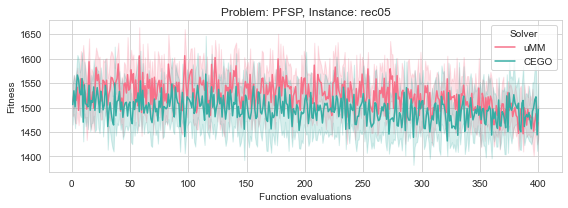

Instance:  rec13
Saving to img/fitness_real_pfsp_rec13_txt.pdf


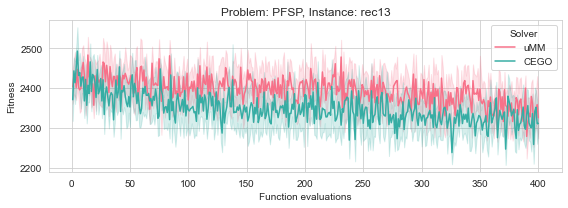

Instance:  rec19
Saving to img/fitness_real_pfsp_rec19_txt.pdf


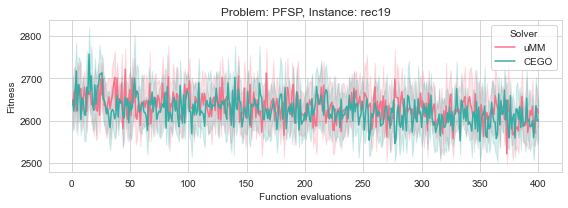

Instance:  rec31
Saving to img/fitness_real_pfsp_rec31_txt.pdf


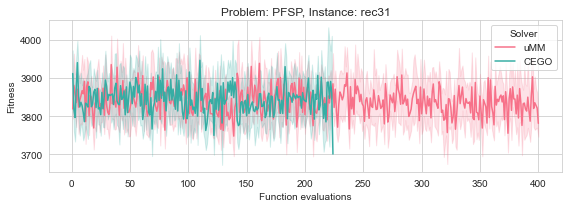

In [5]:
dfselected = pd.read_csv('lop/best_fitness_selected.txt',sep='\t')
dfselected
for inst in dfselected.instance_name.values:
  print("Instance: ", inst)
  df = pd.concat([dfumm[dfumm.instance.str.contains(inst)], dfcego[dfcego.instance.str.contains(inst)]],sort=False)
  if len(df) > 0:
    plt.figure(figsize=(8,3))
    palette = sns.color_palette("husl", len(df['Solver'].drop_duplicates()))
    g = sns.lineplot(x='Function evaluations',y='Fitness',hue='Solver',data=df, palette=palette)
    g.set_title('Problem: '+df.Problem.iloc[0]+', Instance: '+ inst)
    plt.tight_layout()
    filename = 'img/fitness_real_'+df.instance.iloc[0].replace('/','_').replace('.','_')+'.pdf'
    print("Saving to " + filename)
    plt.savefig(filename)
    plt.show()


## Summary of the results

Table with the summary of the results

In [8]:
# MANUEL: Why max() then mean?
# Isn't this enough?
# dfcego.groupby(['Problem','instance'])['run_time'].mean().reset_index()
a = dfcego.groupby(['Problem','instance','seed']).run_time.max().groupby(['Problem','instance']).mean().reset_index().round(1)
a['run_time'] = (a['run_time']/3600).round(1)
a.columns = ['Problem','instance','CEGO Runtime']
b = dfumm.groupby(['Problem','instance','seed']).run_time.max().groupby(['Problem','instance']).mean().reset_index().round(1)
b['run_time'] = (b['run_time']/3600).round(1)
b.columns = ['Problem','instance','UMM Runtime']
dftime = pd.merge(b,a)

a = dfcego.groupby(['Problem','instance','seed']).max()['Function evaluations'].groupby(['Problem','instance']).mean().reset_index()
a.columns = ['Problem','instance','CEGO F. evaluations']
dftime = pd.merge(dftime,a)
a = dfcego.groupby(['Problem','instance','seed']).Fitness.min()
b = dfumm.groupby(['Problem','instance','seed']).Fitness.min()
aa = a.groupby(['Problem','instance']).agg(Fitness_CEGO_mean='mean', Fitness_CEGO_std='std').reset_index() 
bb = b.groupby(['Problem','instance']).agg(Fitness_UMM_mean='mean', Fitness_UMM_std='std').reset_index() 
df = pd.merge(aa,bb)
aa = a.reset_index()
bb = b.reset_index()
for inst in df.instance:
  x,y = aa[aa.instance==inst].Fitness.values,bb[bb.instance==inst].Fitness.values
  cm = sms.CompareMeans(sms.DescrStatsW(x), sms.DescrStatsW(y))
  df.loc[df.instance==inst,'Confidence interval'] = str(tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')]))
df['CEGO fitness'] = df.Fitness_CEGO_mean.round(1).astype(str)+" ("+df.Fitness_CEGO_std.round(1).astype(str)+")"
df['UMM fitness'] = df.Fitness_UMM_mean.round(1).astype(str)+" ("+df.Fitness_UMM_std.round(1).astype(str)+")"
df = df.drop(['Fitness_CEGO_mean'	,'Fitness_CEGO_std',	'Fitness_UMM_mean',	'Fitness_UMM_std'], axis=1)
df = pd.merge(df,dftime, on=['Problem', 'instance'])
df['Instance'] = [i[-1] for i in df.instance.str.split('/').values]
df = df[['Problem', 'Instance','UMM fitness', 'CEGO fitness',	'Confidence interval',	'UMM Runtime',	'CEGO Runtime',	'CEGO F. evaluations']]
df


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [9]:
print(df.to_latex(index=False))

\begin{tabular}{rrrrrlrrrrrrrrlllr}
\toprule
          rho &  phi\_estim &  phi\_sample &  Distance &  Fitness &                                                  x &  m\_ini &  seed &  budget &  budgetMM &  ratio\_samples\_learn &  weight\_mass\_learn &  Function evaluations &       run\_time & Problem &        instance & Solver &  budgetGA \\
\midrule
          NaN &        NaN &         NaN &       NaN &   3775.0 &  [12, 39, 9, 47, 31, 28, 13, 48, 45, 6, 36, 23,... &     10 &     3 &     400 &      10.0 &                  0.1 &                0.9 &                     1 &    3534.958529 &    PFSP &  pfsp/rec31.txt &    uMM &       NaN \\
          NaN &        NaN &         NaN &       NaN &   3956.0 &  [19, 30, 6, 44, 24, 26, 3, 34, 25, 15, 28, 9, ... &     10 &     3 &     400 &      10.0 &                  0.1 &                0.9 &                     2 &    3534.958529 &    PFSP &  pfsp/rec31.txt &    uMM &       NaN \\
          NaN &        NaN &         NaN &       NaN &   38

### Plot of computation times ###

In [13]:
umm_runtime = (dfumm.groupby("instance")["run_time"].mean()/3600.0).round(1).reset_index()
cego_runtime = (dfcego.groupby("instance")["run_time"].mean()/3600.0).round(1).reset_index()
run_time = pd.merge(umm_runtime,cego_runtime, on="instance", suffixes=['_umm','_cego'])
run_time


,instance,run_time_umm,run_time_cego
0,lop/RandA1/N-t1d100.01,3.2,145.1
1,lop/RandA1/N-t1d100.02,3.2,144.7
2,lop/RandA1/N-t1d150.01,6.5,145.7
3,lop/RandA1/N-t1d150.02,6.5,145.3
4,lop/RandA1/N-t1d200.01,10.7,145.4
5,lop/RandA1/N-t1d200.02,10.6,146.0
6,lop/RandA2/N-t2d150.01,7.0,145.5
7,lop/RandA2/N-t2d150.02,7.1,145.0
8,lop/RandA2/N-t2d200.01,11.2,146.7
9,lop/RandA2/N-t2d200.02,11.2,145.7
